# UPDATE
##### · ONLY honest (model) truth, honest permutation score, honest our method score
##### · Trunk: compute the model truth and add to the plot (same truth as in DWC)
##### · Compute "truth" with both the whole set and the honest subset

In [35]:
import sys
import time
import numpy as np
import math
import pandas as pd
from sklearn.utils.validation import check_X_y
from honest_forests.estimators import HonestTreeClassifier
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import check_X_y
from sklearn.utils.multiclass import check_classification_targets
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import scipy.stats as stats

In [36]:
##Simulation Data 
#https://nbviewer.org/github/rflperry/math_tutorials/blob/master/tutorials/StatPatternRecognition/Trunk.ipynb

def simulate(n, d):
    n1 = np.random.binomial(n, 0.5)
    n2 = n - n1
    mu = 1 / np.sqrt(np.arange(1, d+1))

    X = np.vstack((
        np.random.normal(mu, 1, (n1, d)),
        np.random.normal(-mu, 1,  (n2, d))
    ))
    
    return X, np.asarray([1]*n1 + [0]*n2)


In [37]:
def Posterior_After(X,v):
    
    #Duplicate the sigle sample test
    X_testsample_duplicated = np.tile(X,(X_structure.shape[0],1))
    
    ### Replace test data with values from structure subset   
    X_variable = X_structure[:,v]
    
    X_testsample_duplicated[:,v] = X_variable
    X_testsample_duplicated = X_testsample_duplicated.astype(np.float32)
    
    #Obtain the possible leaves with ignoring variable v
    leaves_indicies = np.unique(clf.tree_.apply(X_testsample_duplicated)) 
    value_leaves = np.sum(clf.tree_.value[leaves_indicies], axis=0)
    
    #Calculate the posterior probability for sample x
    
    posterior_proba = value_leaves/np.sum(value_leaves) 
    
    
    return value_leaves,posterior_proba
    
    

### · Sample size = 1000

In [43]:
###Compute te honest truth
d = 20
N = 1000
n = 1000
n_test = 500
n_repeat = 50
ER_Ture = np.zeros((N,d))
for num in range(0,N):
    X_train, y_train = simulate(n = n, d = d)
    X_test, y_test = simulate(n = n_test, d = d)
#     X_test = np.zeros((n,d))
#     y_test = np.zeros((n,1))
#     for k in range(0,n):
#         X_test[k,:] = X_train[k,:]
#         y_test[k] = y_train[k]
    
    error_whole = []
    error_honest = []
    clf_trueHT = HonestTreeClassifier(honest_fraction = 0.8)
    clf_trueHT = clf_trueHT.fit(X_train,y_train)
    y_predict_origin = clf_trueHT.predict(X_test)
    ###Compute original error with the whole set
    er_origin = np.mean(np.abs(y_predict_origin - y_test))
    #print(er_origin)
    
#     ###Compute original error with the honest set
#     X_structure_org = X[clf_trueHT.structure_indices_]
#     X_honest_org = X[clf_trueHT.honest_indices_]
#     y_honest_org  = y_train[clf_trueHT.honest_indices_]
#     leaves_indicies_before_org = clf_trueHT.tree_.apply(X_honest_org.astype(np.float32))
#     value_leaves_before_org = clf_trueHT.tree_.value[leaves_indicies_before_org]
#     classification_before_org = np.zeros(X_honest_org.shape[0])
#     posterior_proba_before_org = np.zeros((X_honest_org.shape[0],2))##n_classes
#     for i in range(0,X_honest_org.shape[0]):
#         posterior_proba_before_org[i,:] = value_leaves_before_org[i,:]/np.sum(value_leaves_before_org[i,:])
#         classification_before_org = posterior_proba_before_org.argmax(1)
#         error_originHT = np.mean(np.abs(y_honest_org - classification_before_org))
    
    
    
    
    ###Compute corrupted error with the whole set 
    y_repeat = np.repeat(y_test,n_repeat)
    X_repeat = np.zeros((X_test.shape[0]*n_repeat,X_test.shape[1]))
    for d_i in range(0,X_test.shape[1]):
        X_repeat[:,d_i] = np.repeat(X_test[:,d_i],n_repeat)
    #print(X_train)
    error_clf = []
    n1 = len(np.argwhere(y_repeat == 1))
    n2 = len(np.argwhere(y_repeat == 0))
    
    for d_i in range(0,X_test.shape[1]):
        X = np.zeros((X_test.shape[0]*n_repeat,X_test.shape[1]))
        for j in range(0,X_test.shape[1]):
            X[:,j] = X_repeat[:,j]
        ##resample for target feature
        mu_i = 1/np.sqrt(d_i+1)
        X_di = np.hstack((np.random.normal(mu_i,1,n1),np.random.normal(-mu_i, 1, n2)))
        #print(len(np.random.normal(-mu_i, 1, n2*n_repeat)))
        X[:,d_i] = X_di
        #print(X[0,:])
        y_predict = clf_trueHT.predict(X)
        error_condition = np.mean(np.abs(y_predict - y_repeat))
        error_clf = np.append(error_clf, error_condition - er_origin)
    ER_Ture[num,:] =  error_clf  
    
    
    

average width of 95% CI of HT True-FIM Score is 0.00040101416106138774


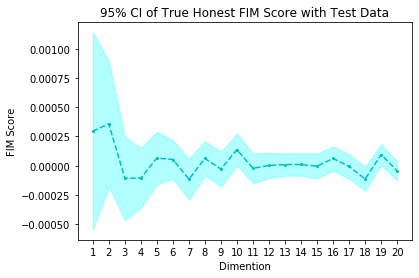

In [45]:
score_Ture_mean = np.mean(ER_Ture,axis = 0)
ci_Ture_low,ci_Ture_up = stats.t.interval(0.95, N-1, loc=np.mean(ER_Ture,axis = 0), scale=stats.sem(ER_Ture,axis = 0))
plt.plot(np.arange(1,d+1,1),score_Ture_mean,'c--',marker='o', markersize=2,label = 'Mean HT True-FIM Score')
plt.fill_between(np.arange(1,d+1,1),ci_Ture_low,ci_Ture_up,alpha = 0.3,color = 'cyan',label = '95% CI of HT True-FIM Score')
width_Ture = np.mean(ci_Ture_up-ci_Ture_low)
print("average width of 95% CI of HT True-FIM Score is " + str(width_Ture))

plt.xticks(np.arange(1, d+1, 1))
#plt.yticks(np.arange(-0.05, 0.3, 0.05))
plt.xlabel('Dimention')
plt.ylabel('FIM Score')
plt.title('95% CI of True Honest FIM Score with Test Data')
plt.show()



In [17]:
##Compute feature importance from FIMs


N = 100
score_ht = np.zeros((N,d))## HFIM
score_htp = np.zeros((N,d))## Permutation FIM with honest tree


for num in range(0,N):
    X_train, y_train = simulate(n=1000, d=d)

    #Train an Honest Tree
    ###We find that the honest tree nust be full trained？
    ###there will be difference for the rank of feature imporatnces  
    t_ht = time.time()
    clf = HonestTreeClassifier(honest_fraction = 0.8)
    clf = clf.fit(X_train, y_train)

    X_structure = X_train[clf.structure_indices_]
    X_honest = X_train[clf.honest_indices_]
    y_honest  = y_train[clf.honest_indices_]
    #np.random.choice(X_structure[:,1],size = 100, replace=True)
    #pd.DataFrame(X_structure[:,1]).sample(n = 100, replace=True)
    #print(y_honest)


    leaves_indicies_before = clf.tree_.apply(X_honest.astype(np.float32))
    value_leaves_before = clf.tree_.value[leaves_indicies_before]
    classification_before = np.zeros(X_honest.shape[0])
    #error_before = np.zeros((X_honest.shape[0],1))

    posterior_proba_before = np.zeros((X_honest.shape[0],2))##n_classes
    value_leaves = np.zeros((X_honest.shape[0],2))
    posterior_proba = np.zeros((X_honest.shape[0],2))
    classification_after = np.zeros(X_honest.shape[0])
    difference_clf = np.zeros(X_honest.shape[0])
    #error_after = np.zeros((X_honest.shape[0],1))

    mean_diff = []


    for k in range(0,X_honest.shape[1]):
        for i in range(0,X_honest.shape[0]):

            ##Compute posterior probability before merging
            posterior_proba_before[i,:] = value_leaves_before[i,:]/np.sum(value_leaves_before[i,:])




            ##Compute posterior probability after merging
            value_leaves[i,:],posterior_proba[i,:] = Posterior_After(X_honest[i,:],k)






        #Compute the difference of posterior possibility for just one class

        ## Get the classification_before result
        classification_before = posterior_proba_before.argmax(1)
        #print(classification_before)

        ## Get the classification_after result
        classification_after = posterior_proba.argmax(1)


        #Calculate classification error before 
        error_before = np.mean(np.abs(y_honest - classification_before))

        #Calculate classification error after merging leaves
        error_after = np.mean(np.abs(y_honest - classification_after))

        #Calculate the difference of classification error
        difference_clf = error_after - error_before

        mean_diff = np.append(mean_diff,difference_clf)
    
    #Save HT socre
    score_ht[num,:] = mean_diff
    
    
    #Calculter Permutation Based HT socre
    r_ht = permutation_importance(clf, X_train, y_train,n_repeats=5,random_state=0)
    score_htp[num,:] = r_ht.importances_mean
    
    

average width of 95% CI of HT True-FIM Score is 0.0001770765773340061
average width of 95% CI of HT-FIM Score is 0.002250184999773287
average width of 95% CI of Permutation Based FIM Score HT is 0.004052317371963031


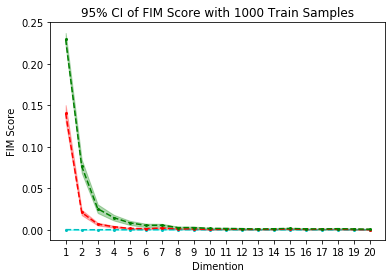

In [19]:
#Calculate 95% CI of HT socre around 100 times iterations
score_Ture_mean = np.mean(ER_Ture,axis = 0)
ci_Ture_low,ci_Ture_up = stats.t.interval(0.95, N-1, loc=np.mean(ER_Ture,axis = 0), scale=stats.sem(ER_Ture,axis = 0))
plt.plot(np.arange(1,d+1,1),score_Ture_mean,'c--',marker='o', markersize=2,label = 'Mean HT True-FIM Score')
plt.fill_between(np.arange(1,d+1,1),ci_Ture_low,ci_Ture_up,alpha = 0.3,color = 'cyan',label = '95% CI of HT True-FIM Score')
width_Ture = np.mean(ci_Ture_up-ci_Ture_low)
print("average width of 95% CI of HT True-FIM Score is " + str(width_Ture))


#Calculate 95% CI of HT socre around 100 times iterations
score_ht_mean = np.mean(score_ht,axis = 0)
ci_ht_low,ci_ht_up = stats.t.interval(0.95, N-1, loc=np.mean(score_ht,axis = 0), scale=stats.sem(score_ht,axis = 0))
plt.plot(np.arange(1,d+1,1),score_ht_mean,'r--',marker='o', markersize=2,label = 'Mean HT-FIM Score')
plt.fill_between(np.arange(1,d+1,1),ci_ht_low,ci_ht_up,alpha = 0.3,color = 'red',label = '95% CI of HT-FIM Score')
width_ht = np.mean(ci_ht_up-ci_ht_low)
print("average width of 95% CI of HT-FIM Score is " + str(width_ht))

#Calculate 95% CI of Permutation Based HT socre around 50 times iterations
score_htp_mean = np.mean(score_htp,axis = 0)
ci_htp_low,ci_htp_up = stats.t.interval(0.95, N-1, loc=np.mean(score_htp,axis = 0), scale=stats.sem(score_htp,axis = 0))
plt.plot(np.arange(1,d+1,1),score_htp_mean,'g--',marker='o', markersize=2,label = 'Mean FIM Score of Permutation Based HT')
plt.fill_between(np.arange(1,d+1,1),ci_htp_low,ci_htp_up,alpha = 0.3,color ='green',label = '95% CI of FIM Score of Permutation Based HT')
width_htp = np.mean(ci_htp_up-ci_htp_low)
print("average width of 95% CI of Permutation Based FIM Score HT is "+str(width_htp))


#Calculate the real importance score


plt.xticks(np.arange(1, d+1, 1))
plt.yticks(np.arange(0, 0.3, 0.05))
plt.xlabel('Dimention')
plt.ylabel('FIM Score')
#plt.legend(loc = 'upper right',fontsize = 'x-small')
plt.title('95% CI of FIM Score with 1000 Train Samples')
#plt.savefig('95% CI of FIM Score with 1000 Train Samples',bbox_inches = 'tight')
plt.show()


